# 实验报告
<font size=4>
    
+ **姓名：于成俊**
+ **学号：2112066**
+ **专业：密码科学与技术**

</font>

## 实验要求

###  **基本要求**
<font size=4>
将数据集winequality-white.csv按照4:1划分为训练集和测试集。
    
1. 构造线性回归模型，并采用批量梯度下降**和**随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。
1. 对于批量梯度下降**和**随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

特别需要注意：
- 划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。
- 需要对数据集进行一定的预处理

</font>



### **中级要求**
<font size=4>
探究回归模型在机器学习和统计学上的差异。
    
- 回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。我们希望同学们从回归模型的角度更加充分地理解机器学习和统计学的区别。
</font>


### **高级要求**
<font size=4>
    
编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法 **均可**）。
</font>

## 实验流程
###  **基本要求**


#### **导入相关包**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### **处理数据**
<font size=4>
首先将数据读取到DataFrame中。
</font>

In [43]:
# 导入数据
data = pd.read_csv("winequality-white.csv")   # DataFrame (4898, 12)
# 提取特征和标签
X = data.iloc[:, 0:-1]    # DataFrame  (4898, 11)
y = data.iloc[:, -1]      # Series     (4898,)

<font size=4>
接着对数据进行预处理，将特征归一化。并用分层采样的方式划分数据集。
</font>

In [44]:
# 归一化
def normalization (X):
    # 计算每列的最小值和最大值
    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)
    X = (X - min_vals)/(max_vals - min_vals)
    return X
    
# 将特征归一化
X = normalization(X)      # DataFrame  (4898, 11)

<font size=4>
最后采用分层采样的方式划分数据集。
</font>

In [45]:
# 划分训练集和测试集（分层采样）
def train_test_split(X, y, test_ratio = 0.2):
    # 获取类别的唯一值
    unique_classes = np.unique(y)   # [3 4 5 6 7 8 9]
    # 初始化训练集和测试集
    X_train = pd.DataFrame()
    y_train = pd.Series()
    X_test = pd.DataFrame()
    y_test = pd.Series()
    # 对每个类别进行分层采样
    for class_label in unique_classes:
        # 获取属于当前类别的样本索引
        class_indices = np.where(y == class_label)[0]

        # 随机打乱当前类别的样本索引顺序
        np.random.shuffle(class_indices)

        # 计算当前类别的样本数量
        num_samples = len(class_indices)

        # 计算训练集和测试集中当前类别的样本数量
        num_train_samples = int((1 - test_ratio) * num_samples)
        num_test_samples = num_samples - num_train_samples

        # 对当前类别进行随机分层采样
        train_indices = class_indices[:num_train_samples]
        test_indices = class_indices[num_train_samples:]

        # 将分层采样得到的样本添加到训练集和测试集中
        X_train = pd.concat([X_train, X.loc[train_indices]])
        y_train = pd.concat([y_train, y.loc[train_indices]])
        X_test = pd.concat([X_test, X.loc[test_indices]])
        y_test = pd.concat([y_test, y.loc[test_indices]])

    # 重置索引，确保索引是连续的
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # 为了向量相乘方便，在X左侧添加全为1的一列
    X_train = pd.concat([pd.DataFrame(np.ones(X_train.shape[0]), columns=['x0']), X_train], axis=1)  # DataFrame(3917,12)
    X_test = pd.concat([pd.DataFrame(np.ones(X_test.shape[0]), columns=['x0']), X_test], axis=1)     # DataFrame(981, 11)

    return X_train, y_train, X_test, y_test

# 划分训练集和测试集
X_train, y_train, X_test, y_test = train_test_split(X, y)   # DF(3917, 12) Se(3917,)  DF(981, 12) Se(981,)

#### **构造回归模型**
<font size=4>
定义用来以随机的方式初始化回归系数的函数。
</font>

In [46]:
# 初始化回归模型权重（回归系数）
def initialize_weights(X_train):
    # 随机初始化的权重矩阵
    W_init = np.random.randn(X_train.shape[1], 1)    # ndarray(12, 1)
    return W_init

<font size=4>
定义用来计算预测值的函数。
</font>

In [47]:
# 根据输入特征和模型权重进行预测（即执行一个矩阵乘法操作）
def predict(X, weights):
    return np.dot(X, weights)

<font size=4>
定义用来计算MSE的函数。
</font>

In [48]:
# 计算MSE
def mean_squared_error(y_true, y_pred):
    # 计算每个样本的预测误差（真实值 - 预测值）的平方
    squared_errors = (y_true - y_pred) ** 2
    # 计算平均平方误差，即将所有样本的平方误差相加并取平均值
    mse = squared_errors.mean()
    # 返回均方误差作为结果
    return mse

#### **采用批量梯度下降优化**
<font size=4>
定义批量梯度下降函数。
</font>

In [49]:
# 批量梯度下降
def batch_gradient_descent(X_train, y_train, learning_rate, num_iterations):
    # 初始化权重
    weights = initialize_weights(X_train)   # ndarray(12, 1)
    # 训练样本的数量
    num_samples = X_train.shape[0]
    # 存储 mse
    mse_values = []
    # 将DataFrame 和 Series 转化为 Numpy数组
    X_train = X_train.values  # ndarray(3917, 12)
    y_train = y_train.values.reshape(-1, 1)  # ndarray(3917, 1)

    for i in range(num_iterations):
        y_pred = predict(X_train, weights)         # ndarray(3917, 1)
        # 计算梯度 （注意维度的匹配） （1, 3917）* （3917, 12)
        gradient = np.dot((y_train - y_pred).reshape(1, -1), X_train) / num_samples   # ndarray(1,12)
        # 更新权重
        weights += learning_rate * gradient.reshape(-1, 1)    # ndarray(12,1)
        mse = mean_squared_error(y_train, y_pred)
        mse_values.append(mse)

    return weights, mse_values

<font size=4>
    
对于**批量梯度下降** 方法，指定迭代次数为250次，采用不同的学习率并进行MSE曲线展示，并输出训练集和测试集的均方误差。
</font>

In [50]:
# 定义迭代次数
num_iterations = 250  # 迭代次数

<font size=4>
学习率为0.001时
</font>

批量梯度下降训练集 MSE: 8.897205091092221
批量梯度下降测试集 MSE: 9.020295808786495


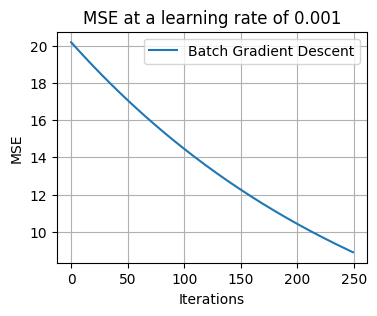

In [51]:
# 定义学习率和迭代次数
learning_rate = 0.001   # 学习率
# 获得优化后的回归系数和训练集的MSE
final_weights, mse_train_batch = batch_gradient_descent(X_train, y_train, learning_rate,
                                                             num_iterations)
# 获得测试集的MSE
y_test_pred_batch = predict(X_test.values, final_weights)
mse_test_batch = mean_squared_error(y_test.values, y_test_pred_batch)

print("批量梯度下降训练集 MSE:", mse_train_batch[-1])
print("批量梯度下降测试集 MSE:", mse_test_batch)

# 画出曲线
plt.figure(figsize=(4, 3))           # 创建一个新的图形对象，指定了图形的大小为 8x6 英寸
plt.plot(range(num_iterations), mse_train_batch, label='Batch Gradient Descent')   # 绘制图形中的数据线
plt.title('MSE at a learning rate of 0.001')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()              # 用于显示图例，其中包含了每条数据线对应的标签
plt.grid(True)            # 将网格线添加到图形中
plt.show()                # 显示了创建的图形。

<font size=4>
学习率为0.003时
</font>

批量梯度下降训练集 MSE: 2.4856086641525956
批量梯度下降测试集 MSE: 2.6813311363641463


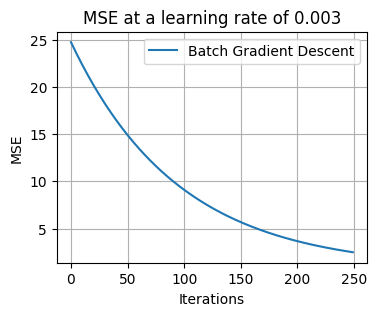

In [52]:
# 定义学习率和迭代次数
learning_rate = 0.003   # 学习率
# 获得优化后的回归系数和训练集的MSE
final_weights, mse_train_batch = batch_gradient_descent(X_train, y_train, learning_rate,
                                                             num_iterations)
# 获得测试集的MSE
y_test_pred_batch = predict(X_test.values, final_weights)
mse_test_batch = mean_squared_error(y_test.values, y_test_pred_batch)

print("批量梯度下降训练集 MSE:", mse_train_batch[-1])
print("批量梯度下降测试集 MSE:", mse_test_batch)

# 画出曲线
plt.figure(figsize=(4, 3))           # 创建一个新的图形对象，指定了图形的大小为 8x6 英寸
plt.plot(range(num_iterations), mse_train_batch, label='Batch Gradient Descent')   # 绘制图形中的数据线
plt.title('MSE at a learning rate of 0.003')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()              # 用于显示图例，其中包含了每条数据线对应的标签
plt.grid(True)            # 将网格线添加到图形中
plt.show()                # 显示了创建的图形。

<font size=4>
学习率为0.01时
</font>

批量梯度下降训练集 MSE: 0.9266088156019072
批量梯度下降测试集 MSE: 0.9330823714378662


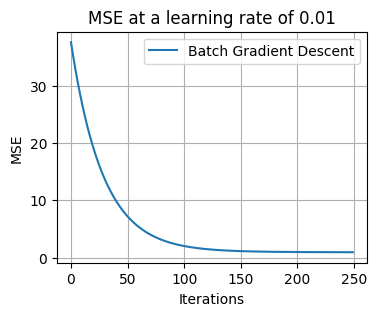

In [53]:
# 定义学习率和迭代次数
learning_rate = 0.01   # 学习率
# 获得优化后的回归系数和训练集的MSE
final_weights, mse_train_batch = batch_gradient_descent(X_train, y_train, learning_rate,
                                                             num_iterations)
# 获得测试集的MSE
y_test_pred_batch = predict(X_test.values, final_weights)
mse_test_batch = mean_squared_error(y_test.values, y_test_pred_batch)

print("批量梯度下降训练集 MSE:", mse_train_batch[-1])
print("批量梯度下降测试集 MSE:", mse_test_batch)

# 画出曲线
plt.figure(figsize=(4, 3))           # 创建一个新的图形对象，指定了图形的大小为 8x6 英寸
plt.plot(range(num_iterations), mse_train_batch, label='Batch Gradient Descent')   # 绘制图形中的数据线
plt.title('MSE at a learning rate of 0.01')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()              # 用于显示图例，其中包含了每条数据线对应的标签
plt.grid(True)            # 将网格线添加到图形中
plt.show()                # 显示了创建的图形。

<font size=4>
学习率为0.3时
</font>

批量梯度下降训练集 MSE: 0.6122150811922684
批量梯度下降测试集 MSE: 0.9623252492722894


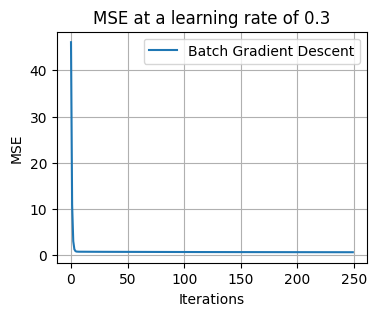

In [54]:
# 定义学习率和迭代次数
learning_rate = 0.3   # 学习率
# 获得优化后的回归系数和训练集的MSE
final_weights, mse_train_batch = batch_gradient_descent(X_train, y_train, learning_rate,
                                                             num_iterations)
# 获得测试集的MSE
y_test_pred_batch = predict(X_test.values, final_weights)
mse_test_batch = mean_squared_error(y_test.values, y_test_pred_batch)

print("批量梯度下降训练集 MSE:", mse_train_batch[-1])
print("批量梯度下降测试集 MSE:", mse_test_batch)

# 画出曲线
plt.figure(figsize=(4, 3))           # 创建一个新的图形对象，指定了图形的大小为 8x6 英寸
plt.plot(range(num_iterations), mse_train_batch, label='Batch Gradient Descent')   # 绘制图形中的数据线
plt.title('MSE at a learning rate of 0.3')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()              # 用于显示图例，其中包含了每条数据线对应的标签
plt.grid(True)            # 将网格线添加到图形中
plt.show()                # 显示了创建的图形。

<font size=4>
学习率为2时
</font>

批量梯度下降训练集 MSE: 5.7095608217005065e+200
批量梯度下降测试集 MSE: 3.6037092792363975e+201


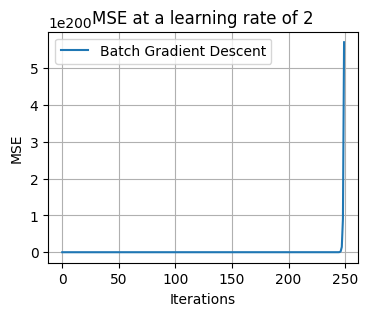

In [55]:
# 定义学习率和迭代次数
learning_rate = 2   # 学习率
# 获得优化后的回归系数和训练集的MSE
final_weights, mse_train_batch = batch_gradient_descent(X_train, y_train, learning_rate,
                                                             num_iterations)
# 获得测试集的MSE
y_test_pred_batch = predict(X_test.values, final_weights)
mse_test_batch = mean_squared_error(y_test.values, y_test_pred_batch)

print("批量梯度下降训练集 MSE:", mse_train_batch[-1])
print("批量梯度下降测试集 MSE:", mse_test_batch)

# 画出曲线
plt.figure(figsize=(4, 3))           # 创建一个新的图形对象，指定了图形的大小为 8x6 英寸
plt.plot(range(num_iterations), mse_train_batch, label='Batch Gradient Descent')   # 绘制图形中的数据线
plt.title('MSE at a learning rate of 2')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()              # 用于显示图例，其中包含了每条数据线对应的标签
plt.grid(True)            # 将网格线添加到图形中
plt.show()                # 显示了创建的图形。

<font size=4>
    
**分析来看：** 学习率为0.01时表现最佳，因为收敛速度适中，不会产生损失值易爆炸的问题，且测试集的MSE最小。
</font>

#### **采用随机梯度下降优化**
<font size=4>
定义随机梯度下降函数。
</font>

In [57]:
#  随机梯度下降优化
def stochastic_gradient_descent(X_train, y_train, learning_rate, num_iterations):
    # 初始化权重
    weights = initialize_weights(X_train)      # ndarray(12,1)
    # 训练样本的数量
    num_samples = X_train.shape[0]
    # 存储 mse
    mse_values = []

    for i in range(num_iterations):
        # 随机选择一个样本的索引
        random_index = np.random.randint(0, num_samples)
        # 获取选定的随机样本
        X_i = X_train.iloc[random_index, :]       # Se(12,)
        y_i = y_train.iloc[random_index]
        # 预测值
        y_pred_i = predict(X_i, weights)         # ndarray(1,)
        # 计算梯度
        gradient_i = np.dot(X_i.values, (y_i - y_pred_i[0]))   # ndarray(12,)
        # 更新权重
        weights += learning_rate * gradient_i.reshape(12, 1)   # ndarray(12,1)
        y_pred = predict(X_train, weights)                     # (3917,1)
        mse = mean_squared_error(y_train.values.reshape(3917, 1), y_pred)
        mse_values.append(mse)

    return weights, mse_values

<font size=4>
    
对于**随机梯度下降** 方法，指定迭代次数为250次，采用不同的学习率并进行MSE曲线展示，并输出训练集和测试集的均方误差。
</font>

<font size=4>
学习率为0.001时
</font>

随机梯度下降训练集 MSE: 12.250002729330632
随机梯度下降测试集 MSE: 12.350569881365002


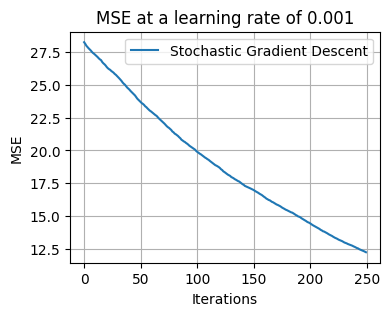

In [68]:
# 定义学习率和迭代次数
learning_rate = 0.001   # 学习率
# 随机梯度下降优化
final_weights, mse_train_sgd = stochastic_gradient_descent(X_train, y_train, learning_rate,
                                                                num_iterations)
# 获得测试集的MSE
y_test_pred_sgd = predict(X_test.values, final_weights)
mse_test_sgd = mean_squared_error(y_test.values, y_test_pred_sgd)

print("随机梯度下降训练集 MSE:", mse_train_sgd[-1])
print("随机梯度下降测试集 MSE:", mse_test_sgd)

plt.figure(figsize=(4, 3))
plt.plot(range(num_iterations), mse_train_sgd, label='Stochastic Gradient Descent')
plt.title('MSE at a learning rate of 0.001')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

<font size=4>
学习率为0.003时
</font>

随机梯度下降训练集 MSE: 3.8225640189467995
随机梯度下降测试集 MSE: 3.9026588617631184


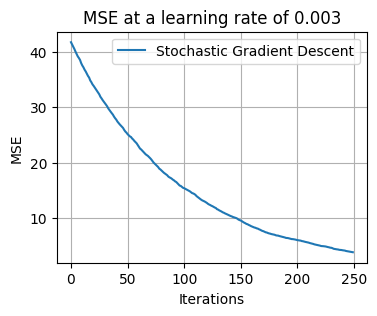

In [69]:
# 定义学习率和迭代次数
learning_rate = 0.003   # 学习率
# 随机梯度下降优化
final_weights, mse_train_sgd = stochastic_gradient_descent(X_train, y_train, learning_rate,
                                                                num_iterations)
# 获得测试集的MSE
y_test_pred_sgd = predict(X_test.values, final_weights)
mse_test_sgd = mean_squared_error(y_test.values, y_test_pred_sgd)

print("随机梯度下降训练集 MSE:", mse_train_sgd[-1])
print("随机梯度下降测试集 MSE:", mse_test_sgd)

plt.figure(figsize=(4, 3))
plt.plot(range(num_iterations), mse_train_sgd, label='Stochastic Gradient Descent')
plt.title('MSE at a learning rate of 0.003')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

<font size=4>
学习率为0.01时
</font>

随机梯度下降训练集 MSE: 0.7482967093737305
随机梯度下降测试集 MSE: 1.0309907935298128


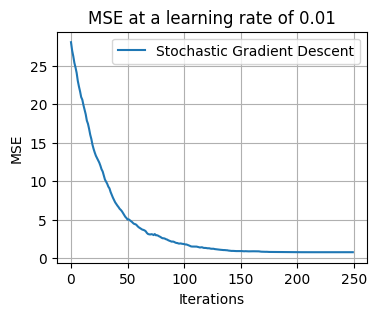

In [70]:
# 定义学习率和迭代次数
learning_rate = 0.01   # 学习率
# 随机梯度下降优化
final_weights, mse_train_sgd = stochastic_gradient_descent(X_train, y_train, learning_rate,
                                                                num_iterations)
# 获得测试集的MSE
y_test_pred_sgd = predict(X_test.values, final_weights)
mse_test_sgd = mean_squared_error(y_test.values, y_test_pred_sgd)

print("随机梯度下降训练集 MSE:", mse_train_sgd[-1])
print("随机梯度下降测试集 MSE:", mse_test_sgd)

plt.figure(figsize=(4, 3))
plt.plot(range(num_iterations), mse_train_sgd, label='Stochastic Gradient Descent')
plt.title('MSE at a learning rate of 0.01')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

<font size=4>
学习率为0.3时
</font>

随机梯度下降训练集 MSE: 0.7078564258171784
随机梯度下降测试集 MSE: 1.0409611467884703


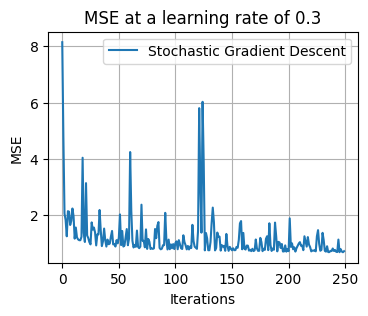

In [71]:
# 定义学习率和迭代次数
learning_rate = 0.3   # 学习率
# 随机梯度下降优化
final_weights, mse_train_sgd = stochastic_gradient_descent(X_train, y_train, learning_rate,
                                                                num_iterations)
# 获得测试集的MSE
y_test_pred_sgd = predict(X_test.values, final_weights)
mse_test_sgd = mean_squared_error(y_test.values, y_test_pred_sgd)

print("随机梯度下降训练集 MSE:", mse_train_sgd[-1])
print("随机梯度下降测试集 MSE:", mse_test_sgd)

plt.figure(figsize=(4, 3))
plt.plot(range(num_iterations), mse_train_sgd, label='Stochastic Gradient Descent')
plt.title('MSE at a learning rate of 0.3')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

<font size=4>
学习率为2时
</font>

随机梯度下降训练集 MSE: 3.1659840033601907e+193
随机梯度下降测试集 MSE: 3.162080209583202e+193


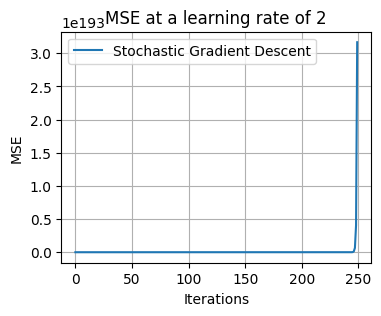

In [72]:
# 定义学习率和迭代次数
learning_rate = 2   # 学习率
# 随机梯度下降优化
final_weights, mse_train_sgd = stochastic_gradient_descent(X_train, y_train, learning_rate,
                                                                num_iterations)
# 获得测试集的MSE
y_test_pred_sgd = predict(X_test.values, final_weights)
mse_test_sgd = mean_squared_error(y_test.values, y_test_pred_sgd)

print("随机梯度下降训练集 MSE:", mse_train_sgd[-1])
print("随机梯度下降测试集 MSE:", mse_test_sgd)

plt.figure(figsize=(4, 3))
plt.plot(range(num_iterations), mse_train_sgd, label='Stochastic Gradient Descent')
plt.title('MSE at a learning rate of 2')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

<font size=4>
    
**分析来看：** 学习率为0.01时表现最佳，因为收敛速度适中，学习过程稳定，不会产生损失值易爆炸和震荡的问题，且测试集的MSE最小。
</font>

###  **中级要求**

<font size=4>   
    
- 目的不同：
    - 机器学习：回归模型通常用于预测目标变量。机器学习的重点是建立一个模型，使其能够对未见数据进行准确的预测。机器学习的主要目标是优化模型的性能，包括降低预测误差，提高泛化性能，以适应复杂的数据关系。
    - 统计学：回归模型通常用于分析数据中的关联和因果关系。统计学的主要关注点是了解数据背后的统计性质和参数估计。回归分析通常用于测试假设、确定变量之间的关系以及估计参数的置信区间。
- 数据处理不同：
    - 机器学习：通常更加强调对大规模和复杂数据集的处理，包括数据清洗、特征工程、降维和模型选择等。特别关注的是如何构建具有强泛化性能的模型。
    - 统计学：数据的质量和采样方法对于参数估计和假设检验至关重要。统计学更注重确保数据满足统计假设，以便进行可靠的推断。
- 模型复杂度不同：
    - 机器学习：可以使用各种高度复杂的回归模型，包括深度神经网络、支持向量机、随机森林等。机器学习模型通常更加强调模型的容量和拟合能力。
    - 统计学：统计回归通常更注重对数据生成过程的理论解释。通常使用线性回归、广义线性模型等较为简单的模型，以便对参数进行统计推断。
- 评估和验证手段不同：
    - 机器学习：在机器学习中，通常使用交叉验证、训练-测试拆分和各种性能指标（如MSE、准确率、召回率等）来评估模型的性能。
    - 统计学：统计回归通常伴随着假设检验、置信区间估计等统计方法，用于确定模型参数的显著性和拟合的质量。
      
</font>

###  **高级要求**

#### **构造岭回归模型**
<font size=4>
    
定义基于**解析法**的岭回归模型
</font>

In [65]:
# 解析法岭回归
def ridge_regression_analytical(X, y, alpha):
    n, d = X.shape               # 获取行数、列数
    A = alpha * np.eye(d)        # 创建大小为 (d, d) 的单位矩阵、 alpha为正则化参数
    A[0, 0] = 0                  # 不惩罚截距项
    theta = np.linalg.inv(X.T.dot(X) + A).dot(X.T).dot(y)
    return theta

#### **求解训练样本的岭回归模型**

In [66]:
# 设置超参数
alpha = 1.0

# 使用解析法计算岭回归模型
final_weights = ridge_regression_analytical(X_train, y_train, alpha)    # ndarray(12,)
y_train_ridge_pred = predict(X_train, final_weights)                    # ndarray(3917,)
y_test_ridge_pred = predict(X_test, final_weights)                      # ndarray(981,)

#### **输出平均训练误差和平均测试误差（MAE）**

In [67]:
# MAE
def mean_error(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    return np.mean(error)

error_train_ridge = mean_error(y_train, y_train_ridge_pred)
error_test_ridge = mean_error(y_test, y_test_ridge_pred)

# 打印结果
print("解析法岭回归：")
print("平均训练误差:", error_train_ridge)
print("平均测试误差:", error_test_ridge)

解析法岭回归：
平均训练误差: 0.5840288173723266
平均测试误差: 0.59383840148351
